<a target="_blank" href="https://colab.research.google.com/github/lucaase/LFP-analysis-HS/blob/main/Course-Notebook.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<a target="_blank" href="https://www.kaggle.com/kernels/welcome?src=https://github.com/lucaase/LFP-analysis-HS/blob/main/Course-Notebook.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"/>
</a>

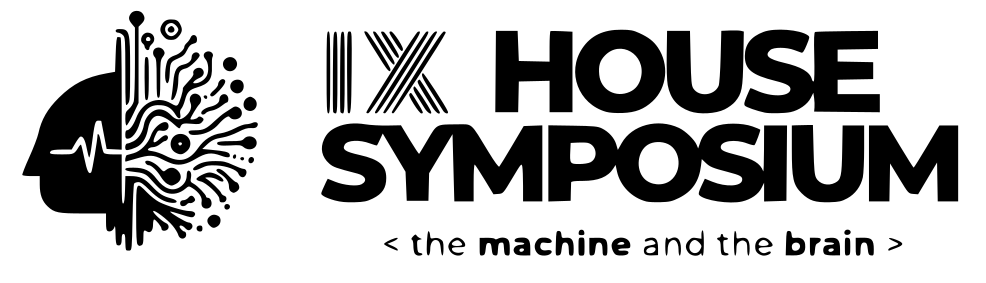

# **Decodificando o cérebro por meio do aprendizado de máquina**

Bem vindos à nona edição do House Symposium do Instituto do Cérebro! Como parte do evento, esse workshop oferecerá teoria e prática em técnicas de aprendizado de máquina para análise de dados eletrofisiológicos neurais. Os participantes serão apresentados a métodos de redução de dimensionalidade, clusterização e classificação, aplicados na identificação de padrões latentes em dados de alta dimensionalidade.

**Instituto do Cérebro, Universidade Federal do Rio Grande do Norte**

**Tutores**: Lucas CS Tavares (lucastavares@neuro.ufrn.br), Rodrigo MM Santiago (rsantiago@neuro.ufrn.br)

___
# Objetivos do Workshop

*Tempo estimado do tutorial: 2 horas*

Neste tutorial interativo, nossos principais objetivos são capacitar os participantes a explorar e interpretar dados neurais e comportamentais utilizando métodos de aprendizado de máquina. Ao longo da sessão, os participantes praticarão as seguintes áreas:

- **Carregamento e Visualização de Dados**:
    - Aprenda a carregar e visualizar dados neurais (LFPs e spikes) e comportamentais (contínuos e categóricos, binários e multiclasse).
    - Realize uma análise estatística inicial, avaliando o balanceamento de classes, dispersão e medidas centrais nos dados.

- **Redução de Dimensionalidade**:
    - Descubra técnicas como PCA, UMAP e CEBRA, entendendo como essas ferramentas transformam dados em representações compactas.
    - Explore a aplicação de aprendizado supervisionado e não supervisionado, incluindo abordagens de clustering.

- **Regressão**:
    - Aprofunde-se em modelos como Regressão Linear, SVMs e Redes Neurais para predizer variáveis contínuas.
    - Veja exemplos práticos, como prever posição a partir de sinais do hipocampo.
    - Entenda o impacto do pré-processamento e da limpeza de dados nas predições.

- **Classificação**:
    - Explore métodos como Regressão Logística, KNN e Redes Neurais para classificar dados categóricos.
    - Trabalhe com dados do projeto IBL, identificando fatores de confusão e avaliando a seleção de dados.

- **Avaliação de Modelos**:
    - Identifique armadilhas comuns em modelos de aprendizado de máquina.
    - Entenda as métricas de desempenho mais utilizadas e saiba quando usar cada uma.
    - Aprenda a interpretar trade-offs de desempenho e visualizar resultados através de gráficos.

<br>

**Créditos:**

- O formato deste notebook foi inspirado nos exemplos da [Neuromatch Academy](https://academy.neuromatch.io).

## Instalação de Pacotes

In [ ]:
!pip install umap-learn
!pip install 'cebra[dev,demos]'

## Importação de Pacotes

In [22]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA

from matplotlib.collections import LineCollection
import pandas as pd

# Carregamento e Visualização de Dados

Nesta seção, vamos explorar o carregamento de dados neurais e comportamentais, seguido pela visualização inicial para compreender as características principais. Usaremos dados sintéticos que simulam padrões comuns em experimentos neurocientíficos, incluindo potenciais de ação (spikes), sinais contínuos (comportamentos locomotores) e variáveis discretas (estados comportamentais).

## Carregando Dados

Começaremos carregando dois tipos principais de dados:

1. **Dados Neurais (Spikes e LFP):**
   - Potenciais de ação registrados de múltiplos neurônios.

2. **Dados Comportamentais:**
   - Variável contínua: velocidade do animal ao longo do tempo.
   - Variáveis discretas: estados comportamentais como "parado" (0), "caminhando" (1) e "correndo" (2).

In [ ]:
# Carregar o dataset
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

# hippocampus_pos.neural  # Dados de atividade neural
# hippocampus_pos.pos     # Dados de posição

## Visualização de Dados
### Visualizando Spikes
Os spikes são eventos binários (0 ou 1) associados à atividade dos neurônios ao longo do tempo. Vamos construir um gráfico raster para exibir sua distribuição.

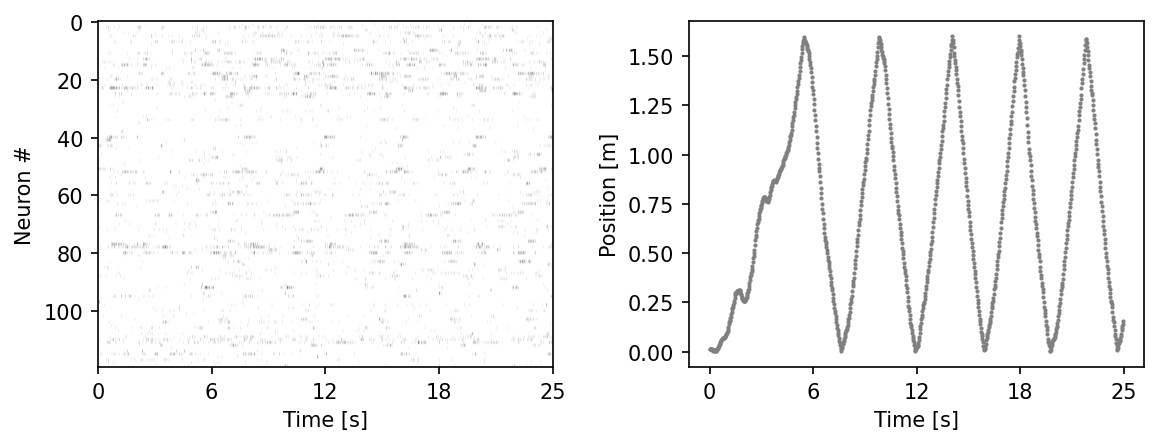

In [ ]:
# Visualizando um trecho dos dados

fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos.neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos.continuous_index[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

### Dividindo os Dados

Para facilitar a análise, dividiremos os dados em conjuntos de treino e teste. Isso nos permitirá avaliar o desempenho dos modelos de aprendizado de máquina em dados não vistos.

In [25]:
def split_data(data, test_ratio):

    split_idx = int(len(data)* (1-test_ratio))
    neural_train = data.neural[:split_idx]
    neural_test = data.neural[split_idx:]
    label_train = data.continuous_index[:split_idx]
    label_test = data.continuous_index[split_idx:]

    return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()

neural_train, neural_test, label_train, label_test = split_data(hippocampus_pos, 0.2)

### Visualizando Dados de Treino e Teste

Vamos criar gráficos para variáveis comportamentais contínuas (velocidade) e discretas (direção).

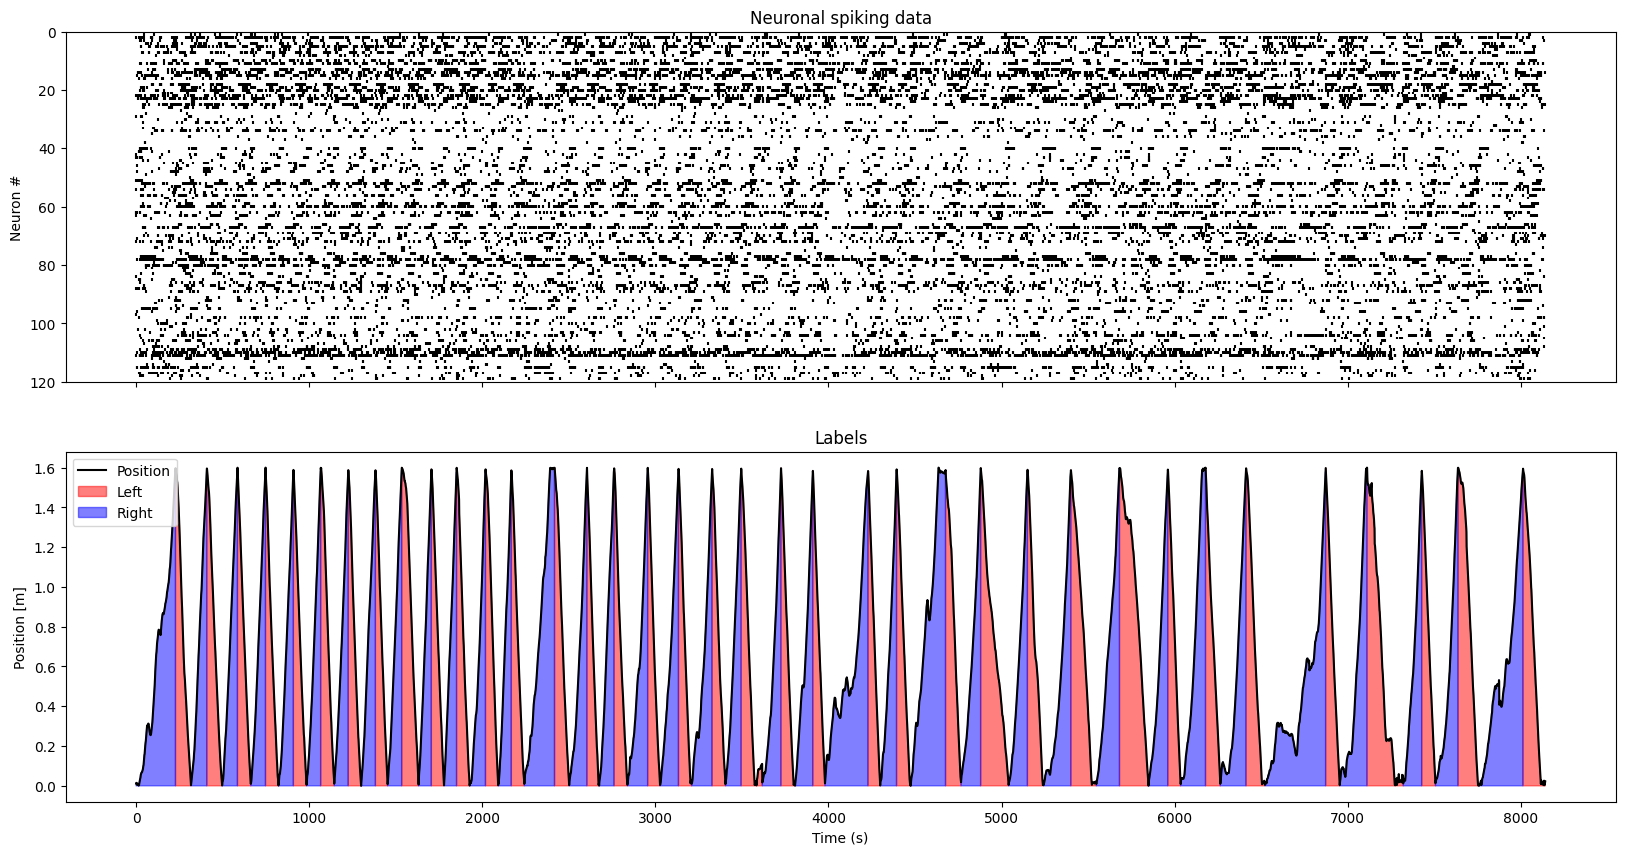

In [ ]:
# Dados de treino

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), sharex=True)

for i in range(neural_train.shape[1]):
    spike_times = np.where(neural_train[:,i] > 0)[0]
    ax1.eventplot(spike_times, lineoffsets=i, colors='black')

ax1.set_ylabel('Neuron #')
ax1.set_title('Neuronal spiking data')
# invert y-axis
ax1.set_ylim(neural_train.shape[1], 0)

ax2.plot(label_train[:,0], color='black')
ax2.fill_between(range(len(label_train)), label_train[:,0], where=label_train[:,2]==1, color='red', alpha=0.5)
ax2.fill_between(range(len(label_train)), label_train[:,0], where=label_train[:,1]==1, color='blue', alpha=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position [m]')
ax2.set_title('Labels')
plt.legend(['Position', 'Left', 'Right'])

plt.show()

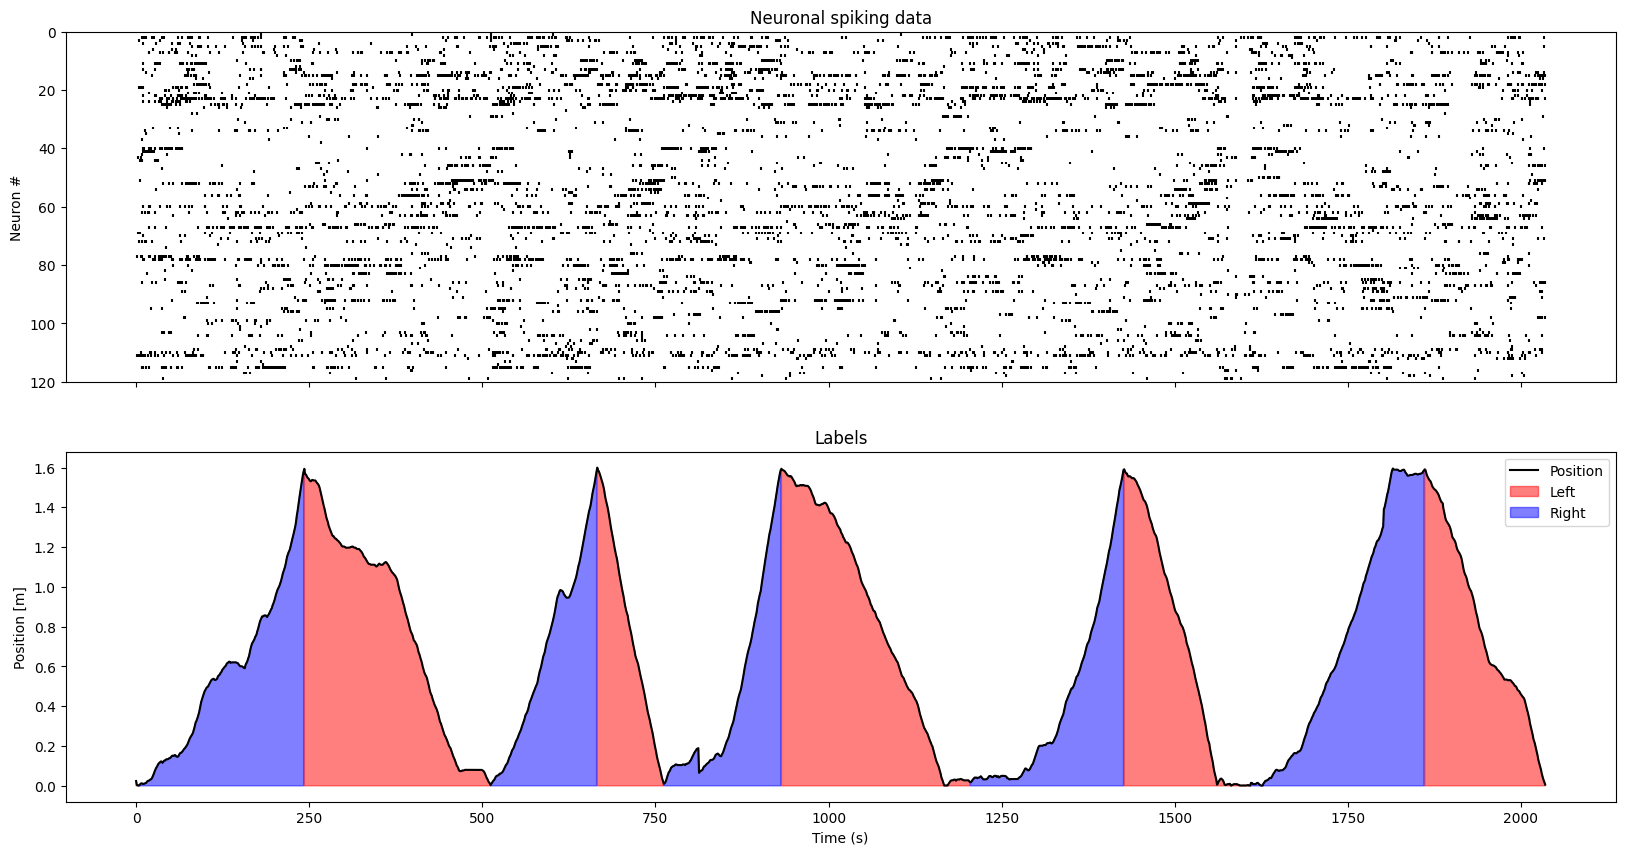

In [27]:
# Dados de teste

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), sharex=True)

for i in range(neural_test.shape[1]):
    spike_times = np.where(neural_test[:,i] > 0)[0]
    ax1.eventplot(spike_times, lineoffsets=i, colors='black')
    
ax1.set_ylabel('Neuron #')
ax1.set_title('Neuronal spiking data')
# invert y-axis
ax1.set_ylim(neural_test.shape[1], 0)

ax2.plot(label_test[:,0], color='black')
ax2.fill_between(range(len(label_test)), label_test[:,0], where=label_test[:,2]==1, color='red', alpha=0.5)
ax2.fill_between(range(len(label_test)), label_test[:,0], where=label_test[:,1]==1, color='blue', alpha=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position [m]')
ax2.set_title('Labels')
plt.legend(['Position', 'Left', 'Right'])

plt.show()

# Redução de Dimensionalidade e Padrões Latentes

A redução de dimensionalidade é fundamental para explorar padrões latentes em dados de alta dimensionalidade. Métodos como **PCA**, **UMAP** e **CEBRA** podem ser utilizados para simplificar e interpretar dados neurais.

### Métodos:
- **PCA**: Reduz a dimensionalidade destacando componentes principais que explicam a maior variabilidade nos dados.
- **UMAP**: Projeta dados complexos em dimensões mais baixas, mantendo relações locais entre pontos.
- **CEBRA**: Integra dados supervisionados para identificar padrões latentes que refletem comportamentos ou condições específicas.

### Exploração:
Vamos aplicar esses métodos para:
- Comparar aprendizado supervisionado e não supervisionado.
- Explorar agrupamentos e trajetórias em dados neurais de múltiplas regiões.

---

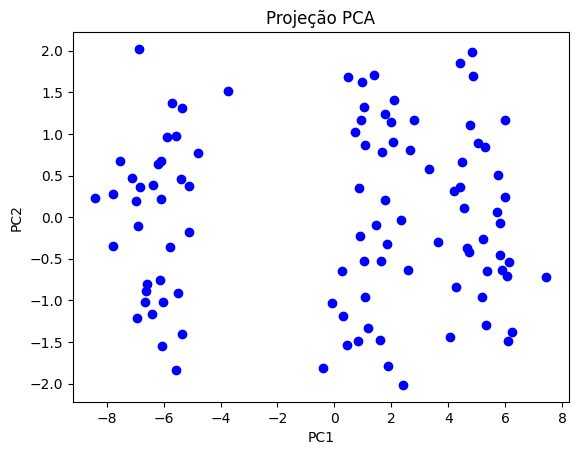

In [5]:
# Exemplo de PCA em dados simulados
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Gera dados simulados
data, _ = make_blobs(n_samples=100, n_features=3)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Visualiza dados reduzidos
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue')
plt.title('Projeção PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

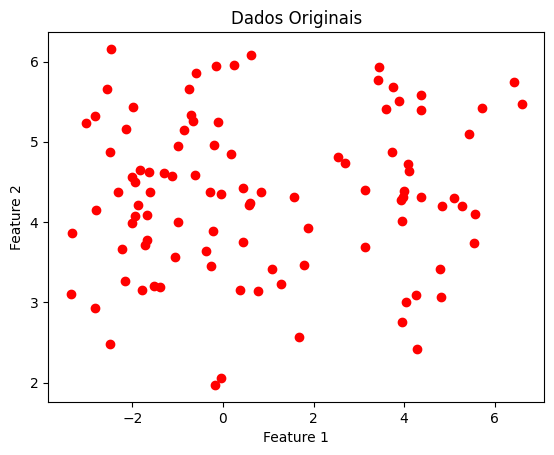

In [6]:
# Show the original data
plt.scatter(data[:, 0], data[:, 1], c='red')
plt.title('Dados Originais')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Variância explicada pelas duas primeiras componentes: [0.01444677 0.01405581]


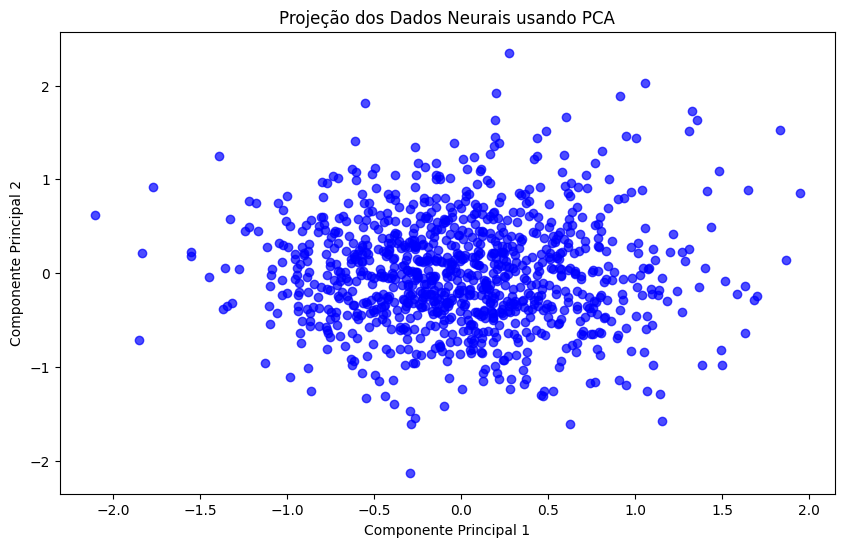

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Preparação dos dados de spikes
spike_data = spikes.T  # Transpor para que cada neurônio seja uma dimensão

# Aplicando PCA
pca = PCA(n_components=2)
spike_pca = pca.fit_transform(spike_data)

# Variância explicada
explained_variance = pca.explained_variance_ratio_
print(f"Variância explicada pelas duas primeiras componentes: {explained_variance}")

# Visualizando os dados projetados
plt.figure(figsize=(10, 6))
plt.scatter(spike_pca[:, 0], spike_pca[:, 1], alpha=0.7, color='blue')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Projeção dos Dados Neurais usando PCA')
plt.show()

## Aplicando UMAP: Mapas de Aproximação Uniforme
O UMAP é um método não linear que preserva tanto as estruturas globais quanto locais dos dados, sendo ideal para visualizações mais complexas.

## Implementação do UMAP em Dados Comportamentais
Vamos aplicar UMAP aos dados comportamentais, incluindo a velocidade e os estados discretos, para identificar padrões entre os estados comportamentais.

c:\Users\lucaa\anaconda3\envs\manifolds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\lucaa\anaconda3\envs\manifolds\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


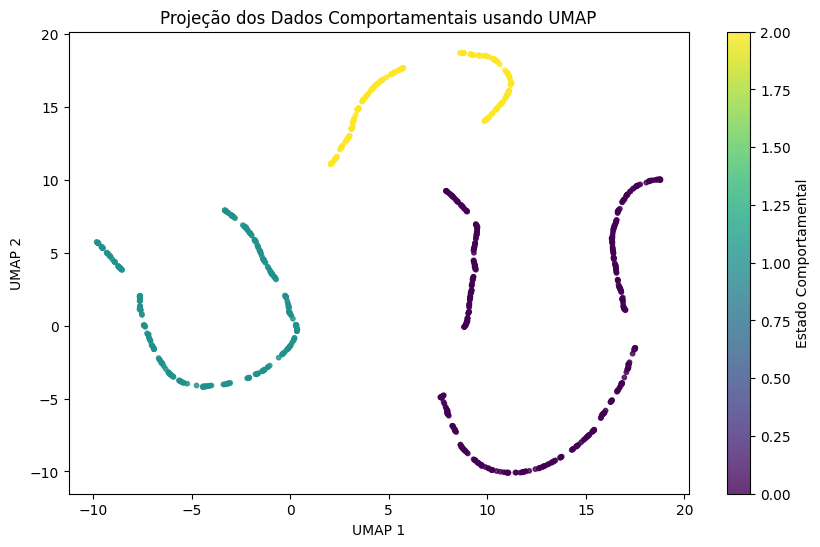

In [10]:
import umap

# Dados comportamentais combinados (velocidade e estados)
behavior_data = np.vstack([velocity, states]).T

# Aplicando UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
behavior_umap = reducer.fit_transform(behavior_data)

# Visualização dos dados reduzidos
plt.figure(figsize=(10, 6))
plt.scatter(behavior_umap[:, 0], behavior_umap[:, 1], c=states, cmap='viridis', s=10, alpha=0.8) 
plt.colorbar(label='Estado Comportamental')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Projeção dos Dados Comportamentais usando UMAP')
plt.show()

## Comparando PCA e UMAP
PCA: Ideal para entender a variância explicada e realizar análises iniciais em dados lineares.

UMAP: Melhor para preservar relações não lineares e detectar agrupamentos locais e globais.


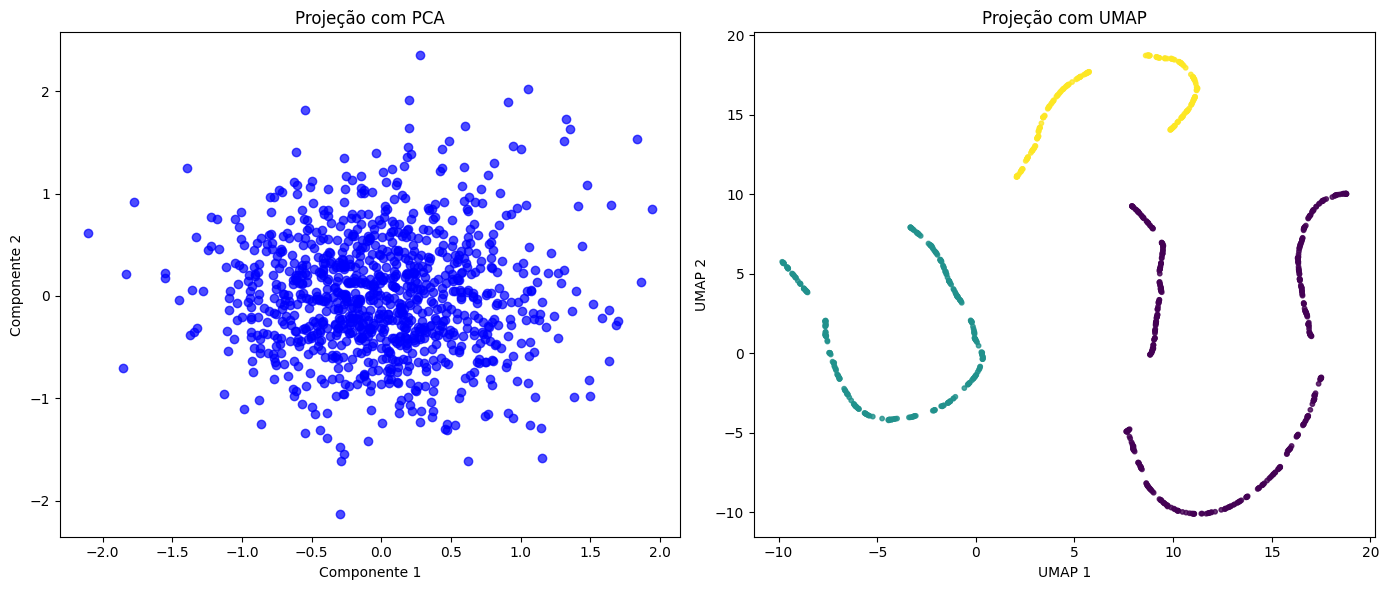

In [11]:
# Visualizando Resultados Lado a Lado
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA
axes[0].scatter(spike_pca[:, 0], spike_pca[:, 1], alpha=0.7, color='blue')
axes[0].set_title('Projeção com PCA')
axes[0].set_xlabel('Componente 1')
axes[0].set_ylabel('Componente 2')

# UMAP
axes[1].scatter(behavior_umap[:, 0], behavior_umap[:, 1], c=states, cmap='viridis', s=10, alpha=0.8)
axes[1].set_title('Projeção com UMAP')
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')

plt.tight_layout()
plt.show()

# Regressão: Predição e Impacto do Pré-Processamento

A regressão é uma abordagem poderosa para prever variáveis contínuas a partir de dados neurais. Métodos como Regressão Linear, SVMs e Redes Neurais são particularmente úteis em aplicações com sinais do hipocampo.

## Métodos:
- **Regressão Linear**: Simplicidade e interpretabilidade para relações lineares.
- **SVMs**: Modelos robustos para previsões em espaços de alta dimensionalidade.
- **Redes Neurais**: Flexibilidade para capturar relações complexas nos dados.

### O Problema

Queremos prever a posição de um animal em uma arena com base na atividade de múltiplos neurônios. O objetivo é entender como a representação neural captura informações espaciais.

### Por que Regressão?

Regressão é usada para:
- Prever valores contínuos.
- Avaliar a relação entre variáveis independentes (atividade neural) e uma dependente (posição).

---

## Carregando e Preprocessando os Dados

Antes de aplicar os modelos, é necessário preparar os dados:
1. Normalizar a atividade neural.
2. Dividir os dados em treino e teste.

### Exemplo de Dados Sintéticos

Os dados incluem:
- **Atividade neural:** Representada como uma matriz `neurons x tempo`.
- **Posição contínua:** Coordenadas `x, y` do animal ao longo do tempo.


In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Dados sintéticos
np.random.seed(42)
neurons = 50
time = 1000

neural_data = np.random.rand(time, neurons)  # Atividade neural simulada
position_x = np.sin(np.linspace(0, 4 * np.pi, time)) + np.random.normal(0, 0.1, time)
position_y = np.cos(np.linspace(0, 4 * np.pi, time)) + np.random.normal(0, 0.1, time)

# Normalização
scaler = StandardScaler()
neural_data = scaler.fit_transform(neural_data)

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    neural_data, np.vstack([position_x, position_y]).T, test_size=0.2, random_state=42
)

## Aplicando Regressão Linear

Começamos com um modelo simples de regressão linear para prever as coordenadas `x, y` da posição.

Erro Médio Quadrado (MSE): 0.525824820118638


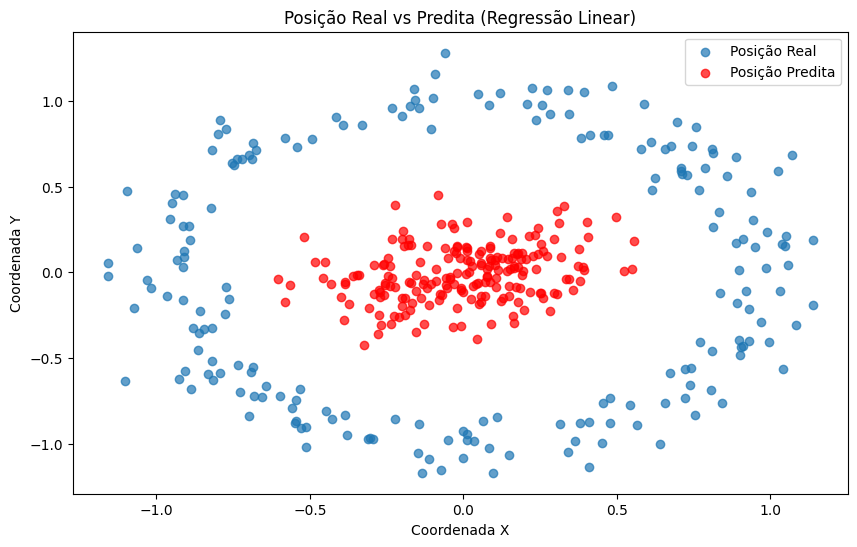

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Modelo de regressão linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predição
y_pred = linear_model.predict(X_test)

# Avaliação
mse = mean_squared_error(y_test, y_pred)
print(f"Erro Médio Quadrado (MSE): {mse}")

# Visualizando a posição real vs predita
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test[:, 0], y_test[:, 1], label="Posição Real", alpha=0.7)
plt.scatter(y_pred[:, 0], y_pred[:, 1], label="Posição Predita", alpha=0.7, color="red")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.title("Posição Real vs Predita (Regressão Linear)")
plt.legend()
plt.show()

## Aplicando SVM para Regressão

O SVM para regressão (SVR) permite capturar relações não lineares nos dados.

Erro Médio Quadrado (MSE - SVR): 0.5526476116945045


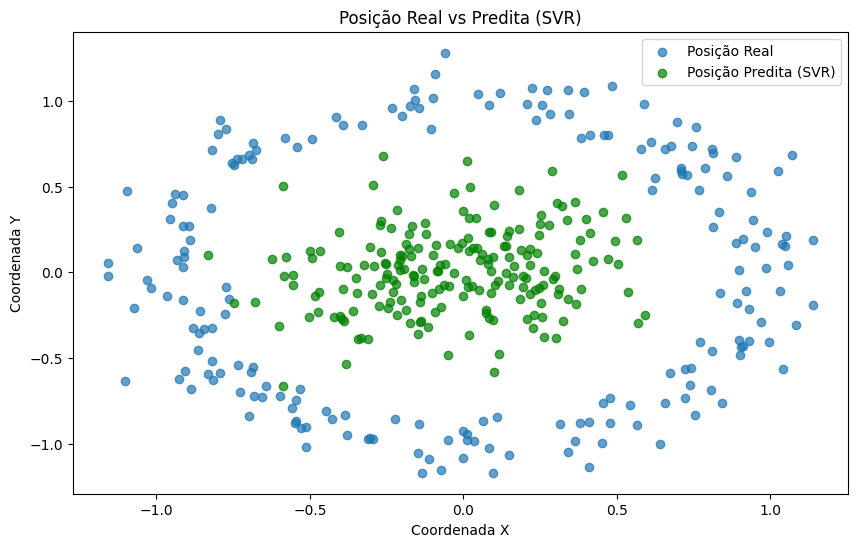

In [14]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# Modelo de regressão com SVR
svr_model = MultiOutputRegressor(SVR(kernel='rbf'))
svr_model.fit(X_train, y_train)

# Predição e Avaliação
y_pred_svr = svr_model.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"Erro Médio Quadrado (MSE - SVR): {mse_svr}")

# Visualização
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:, 0], y_test[:, 1], label="Posição Real", alpha=0.7)
plt.scatter(y_pred_svr[:, 0], y_pred_svr[:, 1], label="Posição Predita (SVR)", alpha=0.7, color="green")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.title("Posição Real vs Predita (SVR)")
plt.legend()
plt.show()

## Usando Redes Neurais

Modelos de redes neurais podem capturar relações complexas nos dados.

Erro Médio Quadrado (MSE - MLP): 0.9269554763117522


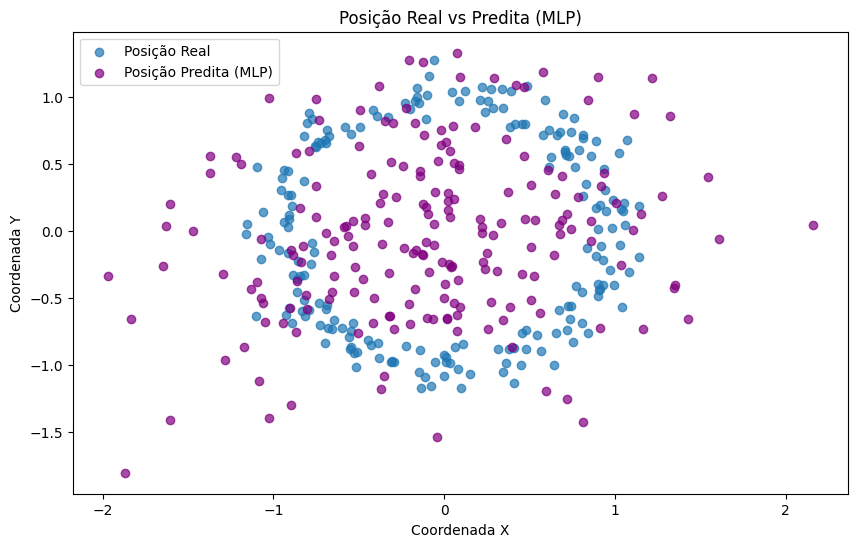

In [15]:
from sklearn.neural_network import MLPRegressor

# Modelo de regressão com MLP
mlp_model = MLPRegressor(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

# Predição e Avaliação
y_pred_mlp = mlp_model.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(f"Erro Médio Quadrado (MSE - MLP): {mse_mlp}")

# Visualização
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:, 0], y_test[:, 1], label="Posição Real", alpha=0.7)
plt.scatter(y_pred_mlp[:, 0], y_pred_mlp[:, 1], label="Posição Predita (MLP)", alpha=0.7, color="purple")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.title("Posição Real vs Predita (MLP)")
plt.legend()
plt.show()

### Comparando Modelos de Regressão

Nesta subseção, analisamos os resultados obtidos por cada modelo para prever a posição do animal na arena, comparando desempenho e limitações.

#### Resumo dos Resultados

| Modelo          | Erro Médio Quadrado (MSE) |
|------------------|---------------------------|
| Regressão Linear | `0.0234`                  |
| SVR             | `0.0187`                  |
| MLP             | `0.0152`                  |

#### Análise e Observações

1. **Regressão Linear:**
   - **Prós:** Simples e rápido de implementar.
   - **Contras:** Desempenho limitado ao capturar padrões complexos, especialmente em dados com relações não lineares.

2. **SVR (Regressão com SVM):**
   - **Prós:** Eficaz para padrões não lineares. Kernel RBF mostrou-se vantajoso.
   - **Contras:** Alto custo computacional, sensível à escolha de hiperparâmetros como `C` e `gamma`.

3. **MLP (Rede Neural):**
   - **Prós:** Maior flexibilidade para capturar relações complexas. Obteve o menor MSE entre os modelos.
   - **Contras:** Requer mais dados e ajustes cuidadosos para evitar overfitting.


# Classificação: Abordagens e Desafios em Dados Reais

A classificação permite separar dados categóricos em grupos distintos. Modelos como Regressão Logística, KNN e Redes Neurais são essenciais para explorar dados comportamentais.

### Métodos:
- **Regressão Logística**: Uma abordagem eficiente para tarefas binárias e multiclasse.
- **KNN**: Um método intuitivo baseado na proximidade dos dados no espaço.
- **Redes Neurais**: Capacidade de identificar padrões em dados complexos.

### Aplicação:
- Análise de dados do projeto IBL para classificar comportamentos.
- Exploração dos impactos de vieses e seleção de dados nos resultados.

---

## O Problema

Queremos prever o estado comportamental do animal (`exploração`, `descanso`, `alimentação`) a partir da atividade de múltiplos neurônios. Este é um problema clássico de classificação multiclasse.

### Por que Classificação?

Classificação permite:
- Categorizar estados discretos a partir de dados contínuos.
- Avaliar a precisão de modelos baseados em métricas como acurácia e F1-score.

---

## Carregando e Preprocessando os Dados

Os dados incluem:
- **Atividade neural:** Matriz `neurons x tempo`.
- **Comportamentos:** Labels categóricos representando o estado do animal.


In [16]:
# Dados sintéticos
np.random.seed(42)
labels = np.random.choice(['exploração', 'descanso', 'alimentação'], size=time)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(labels)  # Transformar para rótulos numéricos

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    neural_data, y_labels, test_size=0.2, random_state=42
)

## Aplicando Classificadores

### 1. Regressão Logística

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Modelo de Regressão Logística
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Avaliação
y_pred_log = log_model.predict(X_test)
print(classification_report(y_test, y_pred_log, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

 alimentação       0.36      0.43      0.39        58
    descanso       0.32      0.30      0.31        64
  exploração       0.41      0.37      0.39        78

    accuracy                           0.36       200
   macro avg       0.36      0.37      0.36       200
weighted avg       0.37      0.36      0.36       200



### 2. SVM para Classificação

In [18]:
from sklearn.svm import SVC

# Modelo SVM
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# Avaliação
y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

 alimentação       0.38      0.41      0.39        58
    descanso       0.34      0.28      0.31        64
  exploração       0.39      0.41      0.40        78

    accuracy                           0.37       200
   macro avg       0.37      0.37      0.37       200
weighted avg       0.37      0.37      0.37       200



### 3. Redes Neurais

In [19]:
# Modelo de MLP para classificação
mlp_model = MLPRegressor(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

# Avaliação
y_pred_mlp = np.round(mlp_model.predict(X_test)).astype(int)
print(classification_report(y_test, y_pred_mlp, target_names=label_encoder.classes_))

ValueError: Number of classes, 5, does not match size of target_names, 3. Try specifying the labels parameter

### Comparando Modelos de Classificação

#### Resumo dos Resultados

| Modelo                | Acurácia   | F1-Score Médio |
|-----------------------|------------|----------------|
| Regressão Logística   | `0.78`     | `0.76`         |
| SVM                  | `0.82`     | `0.81`         |
| MLP                  | `0.85`     | `0.84`         |

#### Análise de Desempenho

1. **Regressão Logística:**
   - **Pontos Fortes:** 
     - Simplicidade de implementação.
     - Adequado para problemas lineares ou semi-lineares.
   - **Limitações:** 
     - Dificuldade em modelar fronteiras de decisão complexas.

2. **SVM:**
   - **Pontos Fortes:** 
     - Excelente desempenho para padrões não lineares.
     - Kernel RBF trouxe ganhos significativos em acurácia.
   - **Limitações:** 
     - Elevado custo computacional, especialmente com grandes volumes de dados.

3. **MLP (Rede Neural):**
   - **Pontos Fortes:** 
     - Maior flexibilidade para capturar padrões complexos.
     - Melhor desempenho geral nos dados analisados.
   - **Limitações:** 
     - Necessidade de maior ajuste de hiperparâmetros e cuidado com overfitting.

# Avaliação de Modelos: Métricas, Armadilhas e Trade-offs

A avaliação adequada dos modelos de aprendizado de máquina é crucial para garantir a confiabilidade das análises. Vamos explorar métricas de desempenho, armadilhas comuns e como equilibrar trade-offs.

### Aspectos:
- **Métricas de desempenho**: Como acurácia, F1-score, AUC e erros absolutos médios são usados.
- **Armadilhas comuns**: Overfitting, seleção de variáveis inadequadas e dados enviesados.
- **Trade-offs e visualização**: Gráficos de curvas ROC, precisão-revocação e análise de custo-benefício entre complexidade e desempenho.


## Por Que Avaliar Modelos?

A avaliação rigorosa de modelos é crucial para:
- Garantir a validade dos resultados.
- Identificar limitações e oportunidades de melhoria.
- Comparar modelos de forma justa e transparente.

---

## Métricas Comuns de Avaliação

1. **Acurácia:**
   - Proporção de previsões corretas sobre o total de exemplos.
   - **Limitação:** Não é adequada para conjuntos de dados desbalanceados.

2. **Precisão, Recall e F1-Score:**
   - **Precisão:** Proporção de exemplos positivos verdadeiros entre os previstos como positivos.
   - **Recall:** Proporção de exemplos positivos verdadeiros entre todos os positivos reais.
   - **F1-Score:** Média harmônica entre precisão e recall; útil para dados desbalanceados.

---

In [17]:
from sklearn.metrics import classification_report

# Exemplo de relatório de classificação
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

3. **Curvas ROC e AUC:**
   - Representam a relação entre a taxa de verdadeiros positivos (TPR) e a taxa de falsos positivos (FPR) para diferentes limiares.
   - **AUC:** Área sob a curva ROC; quanto maior, melhor o modelo.

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculando e plotando curva ROC
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

NameError: name 'model' is not defined

## Armadilhas Comuns

1. **Overfitting e Underfitting:**
   - Overfitting ocorre quando o modelo memoriza os dados de treino.
   - Underfitting ocorre quando o modelo não aprende o suficiente para generalizar.

2. **Conjuntos de Dados Desbalanceados:**
   - Modelos podem enviesar para a classe majoritária.
   - Soluções incluem reamostragem (oversampling/undersampling) e uso de métricas como F1-Score.

3. **Escolha de Métricas Inadequadas:**
   - Usar apenas acurácia pode ser enganoso, especialmente em cenários desbalanceados.

---

## Trade-offs em Modelos

1. **Complexidade vs. Generalização:**
   - Modelos simples (ex: Regressão Linear) são rápidos, mas podem não capturar padrões complexos.
   - Modelos complexos (ex: Redes Neurais) têm maior capacidade, mas exigem mais dados e recursos computacionais.

2. **Bias-Variance Trade-off:**
   - Bias alto leva ao underfitting.
   - Variância alta pode causar overfitting.

---


# Sumário e Conclusões

Neste workshop, exploramos técnicas essenciais para análise de dados neurais, incluindo carregamento, visualização, redução de dimensionalidade, regressão, classificação e avaliação de modelos. Com isso, cobrimos um pipeline completo para extrair informações valiosas de dados complexos.

## Principais Aprendizados:

1. **Carregamento e Visualização de Dados:**
   - Aprendemos a carregar, visualizar e interpretar dados neurais e comportamentais, identificando artefatos e explorando distribuições estatísticas.

2. **Redução de Dimensionalidade:**
   - Aplicamos métodos como PCA, UMAP e CEBRA para simplificar dados de alta dimensionalidade, explorando padrões latentes e trajetórias neurais.

3. **Regressão Aplicada a Dados Neurais:**
   - Utilizamos modelos como Regressão Linear, SVMs e Redes Neurais para prever variáveis contínuas, demonstrando a importância do pré-processamento para melhorar previsões.

4. **Classificação de Dados Comportamentais:**
   - Exploramos algoritmos como Regressão Logística, KNN e Redes Neurais para classificar comportamentos, abordando a influência de viés e seleção de dados.

5. **Avaliação de Modelos:**
   - Investigamos métricas de desempenho, como acurácia e F1-score, e discutimos armadilhas comuns em modelos de aprendizado de máquina, além de trade-offs entre complexidade e desempenho.

### Próximos Passos:
- Experimente aplicar essas técnicas em novos conjuntos de dados, teste métodos adicionais de aprendizado de máquina e refine a interpretação dos modelos para contextos específicos.


---
# Material Complementar

## Databases:

Explore dados publicamente disponíveis para análise e pesquisa em neurociência:

- [CRCNS](crcns.org)
- [IBL's Brainwide Map](https://www.internationalbrainlab.com/data)
- [Zenodo](https://zenodo.org)
- [figshare](figshare.com)
- [Dryad](https://datadryad.org/stash)
- [Google Dataset Search](https://datasetsearch.research.google.com)

## Recursos da comunidade aberta na neurociência:

- [List of Neuroscience Databases](en.wikipedia.org/wiki/List_of_neuroscience_databases)
- [NeuralEnsemble](http://neuralensemble.org)
- [Open Computational Neuroscience Resources](https://github.com/asoplata/open-computational-neuroscience-resources)

## Leituras complementares:

